A Notebook based on the American Scientist article 
"New Dilemmas for the Prisoner" by Brian Hayes

http://www.americanscientist.org/issues/pub/new-dilemmas-for-the-prisoner

Or, for a printer friendly version:
http://www.americanscientist.org/issues/id.16112,y.0,no.,content.true,page.1,css.print/issue.aspx

Various strategies are discussed for responding to the prisoner's dilemma problem using only a history of the previous move.  I wanted to code this up in python in order to explore the ideas.
      

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as pw

In [2]:
# There are two basic choices in the prisoner's dilemma: Cooperate or Defect.
# We'll represent those choices like so: cooperate is "c", defect is "d"
# NOTE: the initial condition of "no choice" will be represented by " "
choices = ["c","d"]

# Given the choices of two prisoners, what is the payout for cooperating vs. defecting?
payout = {
    "cc": [3,3],
    "cd": [0,5],
    "dc": [5,0],
    "dd": [1,1],
}
max_payout = max([payout[x][0]+payout[x][1] for x in payout])

# A memory-one strategy
class Strategy(object):
    def __init__(self,coop_probs):
        # input is a list of probabilities for cooperation, given a single prior event history.
        # odds are given for "  ", "cc", "cd", "dc", "dd" prior events where the 1st char your 
        # previous move, 2nd char is your opponent's previous move
        self.probs = {"  ": [coop_probs[0], 1.0-coop_probs[0]], 
                      "cc": [coop_probs[1], 1.0-coop_probs[1]],
                      "cd": [coop_probs[2], 1.0-coop_probs[2]],
                      "dc": [coop_probs[3], 1.0-coop_probs[3]],
                      "dd": [coop_probs[4], 1.0-coop_probs[4]]
                     }
    def get_response(self,prior_event):
        # return "c" or "d" based on your probabilities 
        return choices[np.random.choice(2, 1, p=self.probs[prior_event])[0]]
        
# what are the memory-one strategies you might have
strategies = {
    #                        "  ", "cc", "cd", "dc", "dd"
    "random":      Strategy([ 0.5,  0.5,  0.5,  0.5,  0.5]),
    "defect":      Strategy([ 0.0,  0.0,  0.0,  0.0,  0.0]),
    "pavlov":      Strategy([ 0.5,  1.0,  0.0,  0.0,  1.0]),
    "tit-for-tat": Strategy([ 1.0,  1.0,  1.0,  0.0,  0.0]),
    "cooperate":   Strategy([ 1.0,  1.0,  1.0,  1.0,  1.0]),
    # some interesting fractional probability strategies
    "dictator":    Strategy([ 1/2,  4/5,  2/5,  2/5,  1/5]),
    "extortioner": Strategy([ 1/2, 11/13, 1/2, 7/26,    0]),
    # all 16 binary strategies (some are duplicates)
    "s0000":       Strategy([ 0.5,  0.0,  0.0,  0.0,  0.0,]),
    "s0001":       Strategy([ 0.5,  0.0,  0.0,  0.0,  1.0,]),
    "s0010":       Strategy([ 0.5,  0.0,  0.0,  1.0,  0.0,]),
    "s0011":       Strategy([ 0.5,  0.0,  0.0,  1.0,  1.0,]),
    "s0100":       Strategy([ 0.5,  0.0,  1.0,  0.0,  0.0,]),
    "s0101":       Strategy([ 0.5,  0.0,  1.0,  0.0,  1.0,]),
    "s0110":       Strategy([ 0.5,  0.0,  1.0,  1.0,  0.0,]),
    "s0111":       Strategy([ 0.5,  0.0,  1.0,  1.0,  1.0,]),
    "s1000":       Strategy([ 0.5,  1.0,  0.0,  0.0,  0.0,]),
    "s1001":       Strategy([ 0.5,  1.0,  0.0,  0.0,  1.0,]),
    "s1010":       Strategy([ 0.5,  1.0,  0.0,  1.0,  0.0,]),
    "s1011":       Strategy([ 0.5,  1.0,  0.0,  1.0,  1.0,]),
    "s1100":       Strategy([ 0.5,  1.0,  1.0,  0.0,  0.0,]),
    "s1101":       Strategy([ 0.5,  1.0,  1.0,  0.0,  1.0,]),
    "s1110":       Strategy([ 0.5,  1.0,  1.0,  1.0,  0.0,]),
    "s1111":       Strategy([ 0.5,  1.0,  1.0,  1.0,  1.0,]),
    # TODO search for other fractional strategies
}

class Player(object):
    def __init__(self, strategy):
        self.strategy    = strategy
        self.value       = 0
        self.last_choice = " "
    def respond(self, their_choice):
        self.last_choice = self.strategy.get_response(self.last_choice+their_choice)
        return self.last_choice
    
class Game(object):
    def __init__(self, strategy_name0, strategy_name1, turns):
        self.name0 = strategy_name0
        self.name1 = strategy_name1
        self.player0 = Player(strategies[strategy_name0])
        self.player1 = Player(strategies[strategy_name1])
        self.turns = turns
        # per-turn arrays
        self.player0_choices = []
        self.player1_choices = []
        self.player0_values = []
        self.player1_values = []
    def play(self):
        for i in range(self.turns):
            player0_last_choice = self.player0.last_choice
            player1_last_choice = self.player1.last_choice
            self.player0_choices.append(self.player0.respond(player1_last_choice))
            self.player1_choices.append(self.player1.respond(player0_last_choice))
            values = payout[self.player0.last_choice+self.player1.last_choice]
            self.player0.value += values[0]
            self.player1.value += values[1]
            self.player0_values.append(self.player0.value)
            self.player1_values.append(self.player1.value)
        self.df = pd.DataFrame({
            "player0_choices": self.player0_choices,
            "player0_values": self.player0_values,
            "player1_choices": self.player1_choices,
            "player1_values": self.player1_values
        })
        self.df["values"] = self.df["player0_values"] + self.df["player1_values"]
        self.df["norm_player0_values"] = self.df["player0_values"]/(max_payout*(self.df.index+1))
        self.df["norm_player1_values"] = self.df["player1_values"]/(max_payout*(self.df.index+1))
        self.df["norm_values"] = self.df["values"]/(max_payout*(self.df.index+1))
    def normplot(self):
        ax = self.df.plot(y=["norm_player0_values","norm_player1_values", "norm_values"],
                          color=['g','m','k'],
                         figsize=[12,4])
        lines, labels = ax.get_legend_handles_labels()
        ax.legend([self.name0, self.name1, "values"], loc='best')
        ax.set_ylim([-0.1,1.1])

# utility for interactive plots
def iplot(strategy_a,strategy_b):
    h = Game(strategy_a,strategy_b,1000)
    h.play()
    h.normplot()

Interactively select different strategies to see how they fare in a simulation against each other.

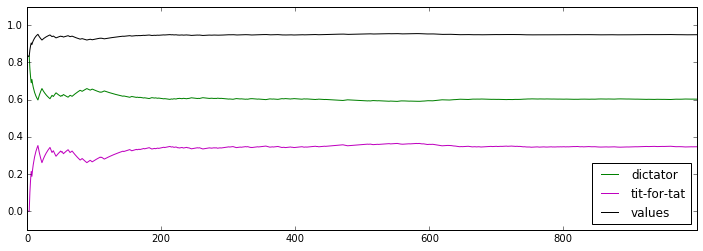

In [3]:
names=list(sorted(strategies.keys()))
pw.interact(iplot,strategy_a=names,strategy_b=names)

In [ ]:
# space for the menus to drop...

















